Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 2

## Assignment
- [ ] Read [“Adopting a Hypothesis-Driven Workflow”](https://outline.com/5S5tsB), a blog post by a Lambda DS student about the Tanzania Waterpumps challenge.
- [ ] Continue to participate in our Kaggle challenge.
- [ ] Try Ordinal Encoding.
- [ ] Try a Random Forest Classifier.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.

## Stretch Goals

### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Do more exploratory data analysis, data cleaning, feature engineering, and feature selection.
- [ ] Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/).
- [ ] Get and plot your feature importances.
- [ ] Make visualizations and share on Slack.

### Reading

Top recommendations in _**bold italic:**_

#### Decision Trees
- A Visual Introduction to Machine Learning, [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/),  and _**[Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)**_
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU)

#### Random Forests
- [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/), Chapter 8: Tree-Based Methods
- [Coloring with Random Forests](http://structuringtheunstructured.blogspot.com/2017/11/coloring-with-random-forests.html)
- _**[Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)**_

#### Categorical encoding for trees
- [Are categorical variables getting lost in your random forests?](https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/)
- [Beyond One-Hot: An Exploration of Categorical Variables](http://www.willmcginnis.com/2015/11/29/beyond-one-hot-an-exploration-of-categorical-variables/)
- _**[Categorical Features and Encoding in Decision Trees](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931)**_
- _**[Coursera — How to Win a Data Science Competition: Learn from Top Kagglers — Concept of mean encoding](https://www.coursera.org/lecture/competitive-data-science/concept-of-mean-encoding-b5Gxv)**_
- [Mean (likelihood) encodings: a comprehensive study](https://www.kaggle.com/vprokopev/mean-likelihood-encodings-a-comprehensive-study)
- [The Mechanics of Machine Learning, Chapter 6: Categorically Speaking](https://mlbook.explained.ai/catvars.html)

#### Imposter Syndrome
- [Effort Shock and Reward Shock (How The Karate Kid Ruined The Modern World)](http://www.tempobook.com/2014/07/09/effort-shock-and-reward-shock/)
- [How to manage impostor syndrome in data science](https://towardsdatascience.com/how-to-manage-impostor-syndrome-in-data-science-ad814809f068)
- ["I am not a real data scientist"](https://brohrer.github.io/imposter_syndrome.html)
- _**[Imposter Syndrome in Data Science](https://caitlinhudon.com/2018/01/19/imposter-syndrome-in-data-science/)**_






### Setup

You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab (run the code cell below).

In [1]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module2')

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv('../data/waterpumps/train_features.csv'), 
                 pd.read_csv('../data/waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv('../data/waterpumps/test_features.csv')
sample_submission = pd.read_csv('../data/waterpumps/sample_submission.csv')
train.shape, test.shape

((59400, 41), (14358, 40))

In [3]:
# Split the train dataframe into training and validation splits
train, validation = train_test_split(train, test_size=0.15, random_state=42)
train.shape, validation.shape

((50490, 41), (8910, 41))

In [4]:
# Need to bring my numbers game
import numpy as np

In [5]:
# Some exploration
for column in train:
    values = train[column].unique()
    if 0 in values:
        print(f"Zeros located in {column}.")
    

Zeros located in id.
Zeros located in amount_tsh.
Zeros located in gps_height.
Zeros located in longitude.
Zeros located in num_private.
Zeros located in district_code.
Zeros located in population.
Zeros located in public_meeting.
Zeros located in permit.
Zeros located in construction_year.


In [6]:
# Find values that happen frequently when construction year is 0
for cols in train.columns:
    mask_con_year = train[train['construction_year']==0]
    if mask_con_year[cols].dtype != 'object':
        pass
    else:
        print('Column:', cols)
        print('Highest:',mask_con_year[cols].mode()[0])
        print('Occurs:',mask_con_year[cols].value_counts()[0],'/', mask_con_year[cols].shape[0])
        print( )

Column: date_recorded
Highest: 2011-07-20
Occurs: 245 / 17543

Column: funder
Highest: Government Of Tanzania
Occurs: 2277 / 17543

Column: installer
Highest: DWE
Occurs: 5502 / 17543

Column: wpt_name
Highest: none
Occurs: 455 / 17543

Column: basin
Highest: Lake Victoria
Occurs: 6567 / 17543

Column: subvillage
Highest: Madukani
Occurs: 169 / 17543

Column: region
Highest: Shinyanga
Occurs: 4082 / 17543

Column: lga
Highest: Rungwe
Occurs: 934 / 17543

Column: ward
Highest: Rujewa
Occurs: 108 / 17543

Column: public_meeting
Highest: True
Occurs: 1701 / 17543

Column: recorded_by
Highest: GeoData Consultants Ltd
Occurs: 17543 / 17543

Column: scheme_management
Highest: VWC
Occurs: 11651 / 17543

Column: scheme_name
Highest: None
Occurs: 528 / 17543

Column: permit
Highest: True
Occurs: 6042 / 17543

Column: extraction_type
Highest: gravity
Occurs: 5743 / 17543

Column: extraction_type_group
Highest: gravity
Occurs: 5743 / 17543

Column: extraction_type_class
Highest: handpump
Occurs: 

In [7]:
from statistics import mean, mode, stdev

In [8]:
import matplotlib.pyplot as plt

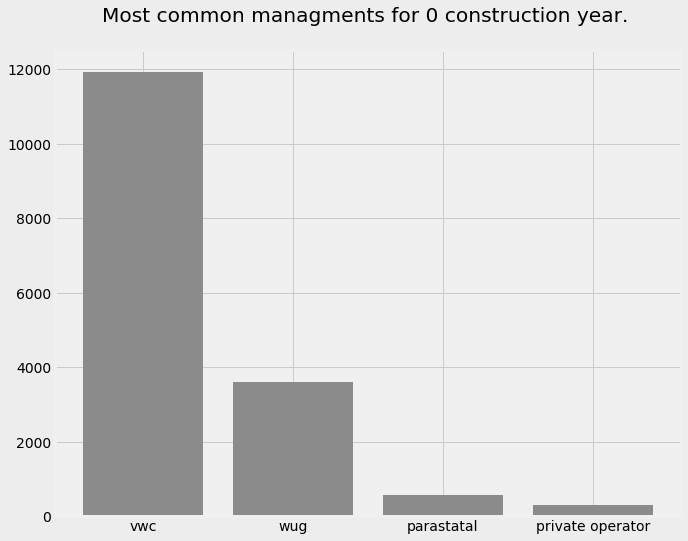

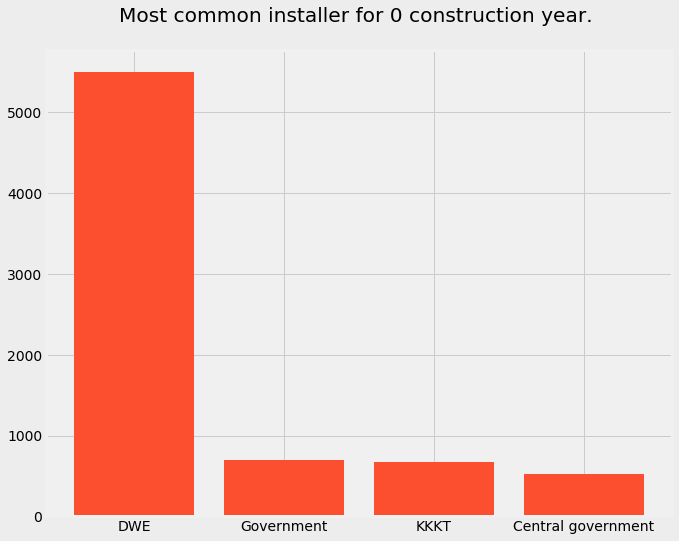

In [9]:
# Visualize some of the relationships between construction year and other features
plt.style.use('fivethirtyeight')

# Groupby management
group_management = train.groupby('construction_year')['management'].value_counts()
plt.figure(facecolor='#ededed', figsize=(10,8))
plt.title('Most common managments for 0 construction year. \n')
plt.bar(group_management[0].index[0:4], group_management[0:4], color='C4')
plt.show()

# Groupby installer
group_installer = train.groupby('construction_year')['installer'].value_counts()
plt.figure(facecolor='#ededed', figsize=(10,8))
plt.title('Most common installer for 0 construction year. \n')
plt.bar(group_installer[0].index[0:4], group_installer[0:4], color='C1')
plt.show()


In [10]:
# Define function to wrangle my data
def func_wrangle(X):
    X = X.copy()
    
    # Set some conditions to fix 0 in numeric columns
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # Replace 0 with NaN
    fill_zeros = ['longitude', 'latitude']
    for column in fill_zeros:
        X[column] = X[column].replace(0, np.nan)
    
    # Drop duplicate columns
    X = X.drop(columns=['quality_group', 'source_type', 'source_class', 'quantity_group', 'payment_type', 
                        'extraction_type', 'extraction_type_group', 'waterpoint_type'])
    
    # Set numeric and Categorical columns
    numbers = X.select_dtypes('number').columns
    categorical_features = X.select_dtypes('object').columns
    
    # Check if categorical has nulls.
    # Get nunique / Less encode
    for column in categorical_features:
        # If null values greater than 0
        if X[column].isnull().sum() > 0:
            # If number of unique options greater than 5
            if X[column].nunique() > 5:
                # Get 5 most frequent, impute Other for everything else
                frequent = X[column].value_counts()[:5].index
                X.loc[~X[column].isin(frequent), column] = 'Other'
            # Less than 5, encode all possible values, Impute Other for everything else
            else:
                possible_values = X[column].unique()
                X.loc[~X[column].isin(possible_values), column] = 'Other'
        # If cardinality greater than 35 values
        if X[column].nunique() > 35:
            # Bring it down to 10
            frequent = X[column].value_counts()[:10].index
            X.loc[~X[column].isin(frequent), column] = 'Other'
    
    # Release the Krakken (again...)
    return X

In [11]:
# Wrangle the data splits
train = func_wrangle(train)
validation = func_wrangle(validation)

In [12]:

# Mask for only non-zero construction year observations. Set X and y
con_X = train[train['construction_year']!=0]
y_mod = con_X['construction_year']
x_mod = con_X[['installer', 'management']]
    
# Import libraries
from sklearn.linear_model import Ridge
import category_encoders as ce
from sklearn.pipeline import make_pipeline
    
# Set up pipeline
con_pipe = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    Ridge(.1, solver='lsqr')
)
    
# Train the model
con_pipe.fit(x_mod, y_mod)

mask = train[train['construction_year']==0]
x_vals = mask[['installer','management']]
predictions = [int(x) for x in con_pipe.predict(x_vals)]
print(f"Fill zeros with {mode(predictions)}.")


Fill zeros with 1997.


In [13]:
# Fill zeros with predicted best value
def fill_con_zero(X):
    X = X.copy()
    feature = ['construction_year']
    for col in feature:
        X[col] = X[col].replace(0, 1997)
    return X

In [14]:
train = fill_con_zero(train)
validation = fill_con_zero(validation)

In [15]:
# See how the wrangle function has affected shape of my splits
train.shape, validation.shape

((50490, 33), (8910, 33))

In [16]:
# I see the correct amount of dimensionality reduction
# Diverge train and validation into feature and target matrix / vector
# Set test matrix

target = 'status_group'
features = train.drop(columns=['id', target]).columns

X_train = train[features]
X_val = validation[features]
y_train = train[target]
y_val = validation[target]
X_test = test[features]

In [17]:
# Prepare the pipeline for modelling
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

In [45]:
# Instantiate the pipeline
model_pipeline = make_pipeline(
    ce.ordinal.OrdinalEncoder(drop_invariant=True),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=100, bootstrap=True, n_jobs=-1, max_depth=22, random_state=42)
)

In [46]:
# Fit model
model_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['date_recorded', 'funder', 'installer',
                                      'wpt_name', 'basin', 'subvillage',
                                      'region', 'lga', 'ward', 'public_meeting',
                                      'recorded_by', 'scheme_management',
                                      'scheme_name', 'permit',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quantity', 'source',
                                      'waterpoint_type...
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=22,
                                        max_features='auto',
                                        ma

In [47]:
# A tad overfit
model_pipeline.score(X_train, y_train)

0.9605664488017429

In [48]:
# About where I would expect
model_pipeline.score(X_val, y_val)

0.8129068462401796

In [49]:
# Put the training and validation sets together for final predictions
Xt = pd.concat([X_train, X_val])
yt = pd.concat([y_train, y_val])

model_pipeline.score(Xt, yt)

In [ ]:
# Set predictions to mysub.csv
y_pred = model_pipeline.predict(X_test)
sample_submission['status_group'] = y_pred
sample_submission.to_csv('C:/Users/Administrator/Desktop/mysub.csv', index=False)
